In [ ]:
!unzip -q "/content/drive/MyDrive/Conglomerate Concrete Crack Detection.zip"

In [ ]:
import tensorflow as tf
import os

def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255


    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask, tf.float32) / 255

    return image, mask


def augment(image, mask):
    # Random flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)


    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)


    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    return image, mask



def create_dataset(image_dir, mask_dir, batch_size=16, augment_data=False):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)


    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size=1000) if augment_data else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset




train_dataset = create_dataset(
    image_dir='/content/Conglomerate Concrete Crack Detection/Train/images',
    mask_dir='/content/Conglomerate Concrete Crack Detection/Train/masks',
    batch_size=16,
    augment_data=True
)

val_dataset = create_dataset(
    image_dir='/content/Conglomerate Concrete Crack Detection/Test/images',
    mask_dir='/content/Conglomerate Concrete Crack Detection/Test/masks',
    batch_size=16,
    augment_data=False
)

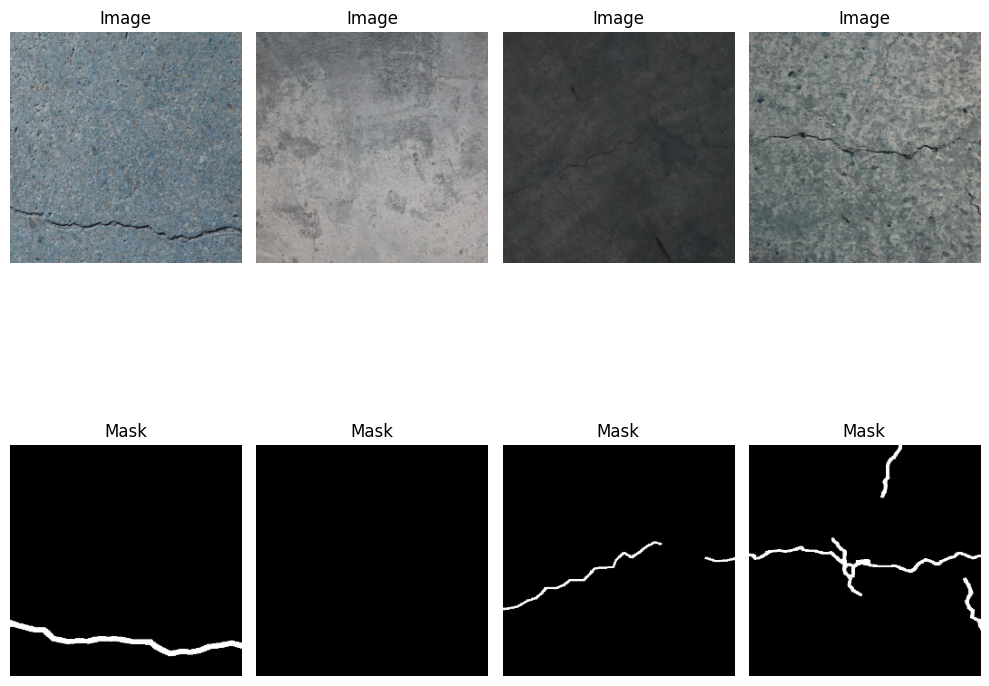

In [ ]:
import random
import matplotlib.pyplot as plt

image_paths = '/content/Conglomerate Concrete Crack Detection/Train/images'
mask_paths = '/content/Conglomerate Concrete Crack Detection/Train/masks'

image_paths = sorted([os.path.join(image_paths, fname) for fname in os.listdir(image_paths)])
mask_paths = sorted([os.path.join(mask_paths, fname) for fname in os.listdir(mask_paths)])


idx = random.sample(range(len(image_paths)), 4)

plt.figure(figsize = (10, 10))

for i in range(4):
    img, msk = load_image_mask(image_paths[idx[i]], mask_paths[idx[i]])

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(msk, cmap = 'gray')
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()


In [ ]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(rate = 0.5)(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(rate = 0.5)(x)

    return x


def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



def build_unet(input_shape):
    inputs = tf.keras.layers.Input(shape = input_shape)


    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)

    model = tf.keras.models.Model(inputs, outputs, name = 'U-Net')
    return model


input_shape = (256, 256, 3)
model = build_unet(input_shape)

In [ ]:
def dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)


    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice


def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss=bce_dice_loss,
    metrics=[dice_coef]
)


model.fit(train_dataset, epochs = 8, validation_data = val_dataset)

Epoch 1/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 164s 217ms/step - dice_coef: 0.2378 - loss: 1.3531 - val_dice_coef: 0.1305 - val_loss: 1.1276
Epoch 2/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - dice_coef: 0.3733 - loss: 1.0258 - val_dice_coef: 0.0725 - val_loss: 1.0890
Epoch 3/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - dice_coef: 0.5106 - loss: 0.8466 - val_dice_coef: 0.0719 - val_loss: 1.0778
Epoch 4/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - dice_coef: 0.5542 - loss: 0.7352 - val_dice_coef: 0.1334 - val_loss: 1.0531
Epoch 5/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - dice_coef: 0.5798 - loss: 0.6561 - val_dice_coef: 0.1820 - val_loss: 1.0074
Epoch 6/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - dice_coef: 0.5894 - loss: 0.6138 - val_dice_coef: 0.2253 - val_loss: 0.9679
Epoch 7/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - dice_coef: 0.6059 - loss: 0.5763 - val_dice_coef: 0.2346 - val_loss: 0.9966
Epoch 8/8
619/619 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - dice_coef: 0

In [ ]:
def visualize_overlay_samples(image_dir, mask_dir, num_samples=5, alpha=0.8):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    sample_indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(8, num_samples * 3))

    for i, idx in enumerate(sample_indices):
        img, msk = load_image_mask(image_paths[idx], mask_paths[idx])

        img = img.numpy()
        msk = msk.numpy()
        # Make mask RGB (same shape as image)
        msk_rgb = tf.concat([msk, msk, msk], axis=-1).numpy()

        # Overlay: Image + (Mask * color)
        overlay = img.copy()
        # Change here: Assign to all 3 color channels
        overlay[msk_rgb[:,:,0] > 0.5] = [1.0, 0, 0]


        blended = (1 - alpha) * img + alpha * overlay

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(blended)
        plt.title(f"Image {idx} with Mask Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

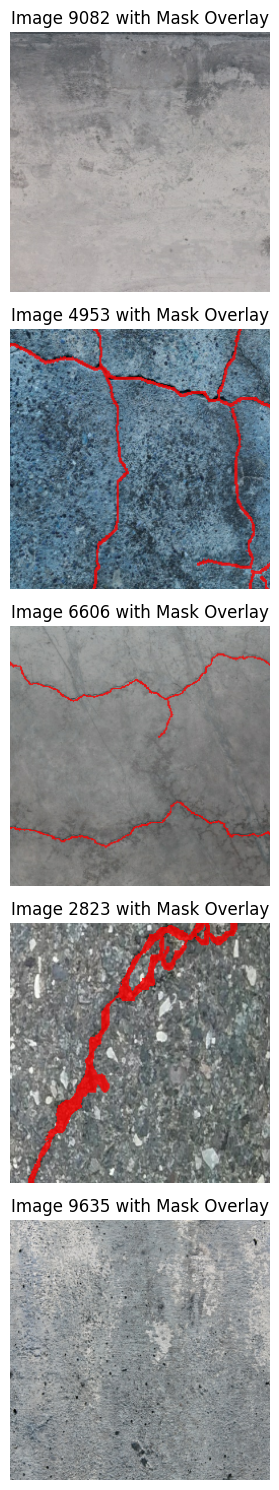

In [ ]:
image_paths = '/content/Conglomerate Concrete Crack Detection/Train/images'
mask_paths = '/content/Conglomerate Concrete Crack Detection/Train/masks'


visualize_overlay_samples(
    image_dir=image_paths,
    mask_dir=mask_paths,
    num_samples=5
)


In [ ]:
model.save('crack_detection.keras')

In [ ]:
!unzip '/content/crack_detection_lite.zip'

unzip:  cannot find or open /content/crack_detection_lite.zip, /content/crack_detection_lite.zip.zip or /content/crack_detection_lite.zip.ZIP.


In [ ]:
import zipfile

# Define filenames
model_filename = 'crack_detection.keras'
zip_filename = 'crack_detection_lite.zip'

# Create zip
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_filename)

print(f'Model zipped successfully as {zip_filename}')


Model zipped successfully as crack_detection_lite.zip


In [ ]:
def visualize_predictions(model, image_dir, mask_dir, num_samples=5, alpha=0.4):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    sample_indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(8, num_samples * 3))

    for i, idx in enumerate(sample_indices):
        # Load image and mask
        img, msk = load_image_mask(image_paths[idx], mask_paths[idx])

        # Get the model prediction (pred mask)
        pred_mask = model.predict(tf.expand_dims(img, axis=0))[0]

        img = img.numpy()
        msk = msk.numpy()

        msk_rgb = tf.concat([msk, msk, msk], axis=-1).numpy()
        pred_rgb = tf.concat([pred_mask, pred_mask, pred_mask], axis=-1)

        gt_overlay = img.copy()

        gt_overlay[msk_rgb[:,:,0] >= 0.5] = [1.0, 0, 0]

        pred_overlay = img.copy()
        pred_overlay[pred_rgb[:,:,0] >= 0.5] = [0, 1.0, 0]


        blended_gt = (1 - alpha) * img + alpha * gt_overlay

        # Blended (predicted mask overlay)
        blended_pred = (1 - alpha) * img + alpha * pred_overlay

        # Display ground truth and predicted mask overlays
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(blended_gt)
        plt.title(f"Ground Truth {idx}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(blended_pred)
        plt.title(f"Prediction {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


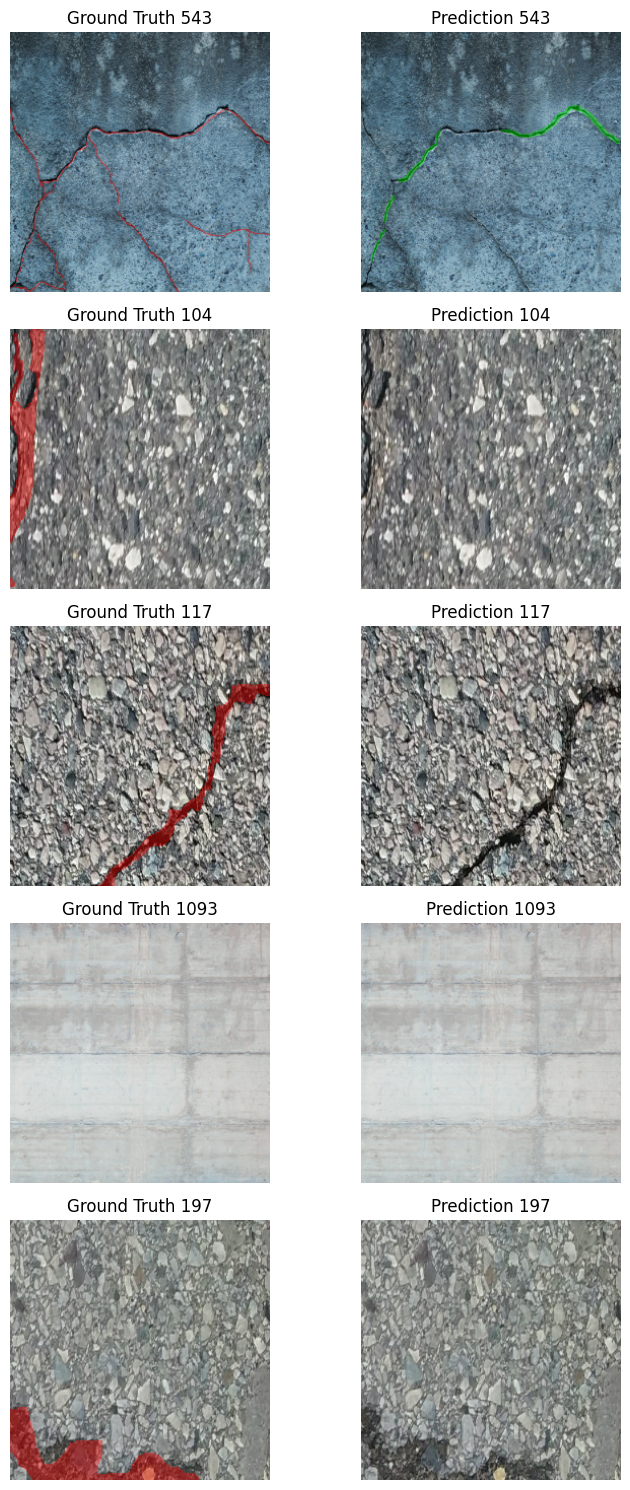

In [ ]:
image_paths = '/content/Conglomerate Concrete Crack Detection/Test/images'
mask_paths = '/content/Conglomerate Concrete Crack Detection/Test/masks'


visualize_predictions(
    model=model,  # Your trained model
    image_dir=image_paths,
    mask_dir=mask_paths,
    num_samples=5
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


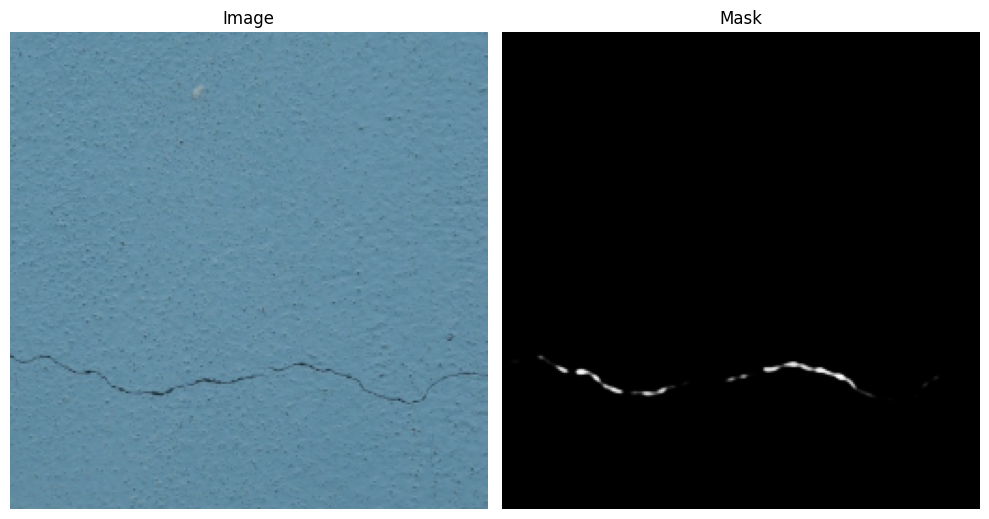

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np


image_paths = '/content/Conglomerate Concrete Crack Detection/Test/images'
mask_paths = '/content/Conglomerate Concrete Crack Detection/Test/masks'

image_paths = sorted([os.path.join(image_paths, fname) for fname in os.listdir(image_paths)])
mask_paths = sorted([os.path.join(mask_paths, fname) for fname in os.listdir(mask_paths)])


idx = random.sample(range(len(image_paths)), 1)

plt.figure(figsize = (10, 10))

idx = np.random.choice(len(image_paths))
img, msk = load_image_mask(image_paths[idx], mask_paths[idx])

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
# Add a new dimension to the image to create a batch of size 1
predicted_mask = model.predict(tf.expand_dims(img, axis=0))[0]
plt.imshow(predicted_mask, cmap = 'gray')
plt.title('Mask')
plt.axis('off')

plt.tight_layout()

In [ ]:
66.7, 70

[4279]